# Selección de clientes GreedyFed - Método basado en rendimiento del modelo

En este notebook vamos a entrenar un modelo de ML utilizando el paradigma de Aprendizaje Federado [1] para los problemas de clasificación de dígitos manuscritos MNIST [2] y clasificación de imágenes a color CIFAR-10 [3]. Usaremos estos dos problemas de visión por computador para la implementación y análisis de rendimiento del método GreedyFed [4] para la selección de clientes.

> [1] https://arxiv.org/abs/1602.05629
>
> [2] http://yann.lecun.com/exdb/mnist
>
> [3] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [4] https://arxiv.org/abs/2312.09108

In [1]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 4.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2587 sha256=62a6d477597a768416ee9f0f5bd577bc8a7597c4d316e60d32f6d54e6dd7acc5
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [2]:
# install Torchvision if not installed
try:
    import torchvision
    print("Torchvision is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency torchvision...")
    !pip install torchvision

Torchvision is installed.


In [3]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy, title="Learning Curves"):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [4]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda'

# Cargar datasets - MNIST, CIFAR-10


## Distribución de los datos

Para la distribución de los datos preparamos una federación para ambos datasets en el que simulamos clientes __heterogéneos__ en cuestión tanto de clases como del tamaño de sus conjuntos de datos. Nos basamos en la federación que realizan en [1].

Para poder crear un escenario de clientes heterogéneos, suponemos un dataset de $10$ clases que puede ser cualquiera de los que estamos utilizando (MNIST o CIFAR-10). Luego realizamos una federación con la siguiente descripción de [1]: _"muestrear dos/diez clases para cada cliente para CIFAR-10/CIFAR-100$^1$; Luego, para cada cliente $i$ y una clase seleccionada $c$, muestreamos $\alpha_{i,c} \sim U(.4, .6)$, y lo asignamos con $\frac{\alpha_{i,c}}{\sum_j{\alpha_{j,c}}}$ de los ejemplos para esta clase. Repetimos lo anterior para $10, 50$ y $100$ clientes."_ De esta forma, creamos una distribución de datos en el que cada cliente tendrán un número de clases diferente al resto y con diferentes tamaños, formando una distribución no-IID de datos.

> $^1$ En nuestro caso solo será para CIFAR-10 y MNIST, es decir, suponemos siempre $10$ clases.
>
> [1] https://arxiv.org/abs/2103.04628.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Para poder federar EMNIST, debemos de crear una configuración con `FedDatasetConfig` para poder especificar como queremos distribuir los datos y a cuántos nodos queremos federarlo y luego utilizar la clase `FedDataDistribution` para poder crear el dataset federado. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [5]:
import math
import numpy as np

from copy import deepcopy
from torchvision import datasets, transforms
from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

K_mnist = 300

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_mnist

# assign a sample proportion for each node-class pair (https://arxiv.org/abs/2404.06127)
num_classes = 10
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of MNIST
flex_dataset_mnist = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33929468.10it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 998382.07it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9000156.68it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2323802.00it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

Realizamos la misma serie de operaciones que con EMNIST, pero esta vez adaptamos a un número de nodos de $K = 100$ (sin contar el servidor). Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

K_cifar = 100

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_cifar

num_classes = 10

# assign a sample proportion for each node-class pair
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data),
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

100%|██████████| 170498071/170498071 [00:02<00:00, 65229334.63it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ unidades la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [7]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Usaremos la red neuronal convolucional utilizada en los experimentos de el algoritmo GreedyFed [1], debido a que es una arquitectura con pocos parámetros a entrenar, lo que nos permite obtener los resultados deseados en poco tiempo. Concretamente, la arquitectura de la red a implementar será la de una CNN estándar que comprende dos capas convolucionales (CONV) $4\times 4$:
- Ambas con $8$ canales de salida.
- Cada uno de ellos activados por ReLU [2].
- Y aplicando _Max Pooling_ $2\times 2$ con _stride_ de $2$ en la salida de cada capa convolucional para reducir la dimensionalidad del los mapas de activación.

Seguido de $1$ capa _Fully-Connected_ de $10$ unidades activada por Softmax para la capa de final de salida.

> [1] https://arxiv.org/abs/2312.09108
>
> [2] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [8]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).

    Model architecture based on GreedyFed experimental setting:
    - https://github.com/pringlesinghal/GreedyFed/blob/b2d928670bcd014035830c531bea9f76c57b4b70/model.py#L46
    """
    def __init__(self, in_channels: int, in_width: int = 32, in_height: int = 32, output_dim: int = 10):
        super(CNN, self).__init__()

        self.in_channels = in_channels
        self.input_w = in_width
        self.input_h = in_height
        self.output_dim = output_dim

        # First CONV layer
        out_channels_conv_1 = 8
        kernel_conv_1_size = 4
        padding_conv_1 = 1
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels=out_channels_conv_1,
            kernel_size=kernel_conv_1_size,
            padding=padding_conv_1,
        )

        output_w_1, output_h_1 = self.__conv_output_dims(
            self.input_w, self.input_h, kernel_conv_1_size, padding_conv_1
        )

        # First MAXPOOL layer
        kernel_pool_size = 2
        stride_pool = 2
        self.pool = nn.MaxPool2d(kernel_size=kernel_pool_size, stride=stride_pool)

        output_w_2, output_h_2 = self.__pool_output_dims(
            output_w_1, output_h_1, kernel_pool_size, stride_pool
        )

        # Second CONV layer
        in_channels_conv_2 = out_channels_conv_1
        out_channels_conv_2 = 8
        kernel_conv_2_size = 4
        padding_conv_2 = 1
        self.conv2 = nn.Conv2d(
            in_channels_conv_2,
            out_channels=out_channels_conv_2,
            kernel_size=kernel_conv_2_size,
            padding=padding_conv_2
        )

        output_w_3, output_h_3 = self.__conv_output_dims(
            output_w_2, output_h_2, kernel_conv_2_size, padding_conv_2
        )

        # after second MAXPOOL layer, compute final out width and height
        output_w_4, output_h_4 = self.__pool_output_dims(
            output_w_3, output_h_3, kernel_pool_size, stride_pool
        )

        # Fully-Connected layer
        self.flatten = nn.Flatten()
        input_size_4 = int(output_w_4 * output_h_4 * out_channels_conv_2)
        self.fc = nn.Linear(input_size_4, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # x = self.flatten(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def __conv_output_dims(self, width: int, height: int, kernel_size: int, padding: int = 1):
        output_w = width - kernel_size + 2 * padding + 1
        output_h = height - kernel_size + 2 * padding + 1
        return output_w, output_h

    def __pool_output_dims(self, width: int, height: int, kernel_size: int, stride: int = 1):
        output_w = np.floor((width - kernel_size) / stride) + 1
        output_h = np.floor((height - kernel_size) / stride) + 1

        return output_w, output_h

## Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

### Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje $^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [9]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(in_channels=cifar_in_channels, output_dim=cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

---
### Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [10]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    return copy.deepcopy(server_flex_model)

### Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [11]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

### Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [12]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

### Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [13]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [14]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

### Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [15]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

### Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria (RandomSampling _baseline_), similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [16]:
from typing import Literal

Problem = Literal["mnist", "cifar"]

def train_n_rounds(pool: FlexPool, n_rounds: int, clients_per_round=20, problem: Problem = "mnist"):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train, transforms=transforms)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

# Seleccionando clientes con GreedyFed

Ahora adaptamos nuestro entorno de Aprendizaje Federado para seleccionar clientes con GreedyFed utilizando las funciones de FLEX. Para ello, vamos a preparar el entorno antes de pasar directamente con el algoritmo de selección.

En primer lugar, GreedyFed [1] define un conjunto de datos de validación que utiliza el algoritmo de aproximación de valores de Shapley GTG-Shapley [2] para poder calcular la contribución marginal de los $M$ clientes seleccionados en la ronda actual. Para esto, el algoritmo GTG-Shapley necesita de un conjunto de validación $\mathcal D_{\text{val}}$ para poder calcular esta contribución. Para ello, separaremos el dataset de entrenamiento en dos subconjuntos de datos: uno de entrenamieto y otro de validación, siendo el tamaño del de validación un $10\%$ de los datos totales de entrenamiento aleatoriamente separados, para lo cual contaríamos con $6000$ ejemplos en MNIST y $5000$ ejemplo en CIFAR-10.

$$
\mathcal D_\text{T} = \mathcal D_\text{train} \cup \mathcal D_\text{val}\\
\begin{cases}
N &= |\mathcal D_\text{T}|,\\
N_\text{val} &= \lfloor 0.1 \times N\rfloor,\\
N_\text{train} &= N-N_\text{val}
\end{cases}
$$

El algoritmo GTG-Shapley es un algoritmo de naturaleza combinatoria, donde en cada ronda sufre una complejidad en tiempo de $\mathcal O(M \log M)$ donde $M$ es el número de clientes seleccionados por ronda (i.e. el _presupuesto_ de clientes seleccionados). Por tanto, la distribución de los datos en este esquema de selección tendrá un número total de clientes $K$ más pequeño que en otros métodos, por lo que establecemos un número de $K=300$ nodos sin contar el servidor central para MNIST y $K=100$ para CIFAR-10 que son valores muy similares usados por los autores de [1].

### Separar conjunto de validación $D_\text{val}$

Dicho lo anterior, federamos de nuevo MNIST para poder definir los parámetros comentados así como en el caso de CIFAR-10.

> [1] https://arxiv.org/abs/2312.09108
>
> [2] https://arxiv.org/abs/2109.02053

In [17]:
import math
from copy import deepcopy

from torchvision import datasets, transforms
from torch.utils.data import random_split

from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

K_mnist = 300

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

# split test data into training and validation datasets (val data ~ 10% of train data)
val_len = math.floor(0.1 * len(train_data))
train_len = len(train_data) - val_len

train_data, val_data = random_split(train_data, [train_len, val_len])

num_classes = 10

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_mnist

# assign a sample proportion for each node-class pair
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

flex_dataset_mnist = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = Dataset.from_torchvision_dataset(test_data)
mnist_val_data = deepcopy(val_data)

/opt/conda/lib/python3.10/site-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(


In [18]:
K_cifar = 100

train_data = datasets.CIFAR10(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

num_classes = 10

# split train data into training and validation datasets (val data ~ 10% of train data)
val_len = math.floor(0.1 * len(train_data))
train_len = len(train_data) - val_len

train_data, val_data = random_split(train_data, [train_len, val_len])

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_cifar

# assign a sample proportion for each node-class pair
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)
cifar_val_data = deepcopy(val_data)

Files already downloaded and verified
Files already downloaded and verified


### Asignar $\mathcal D_\text{val}$ a los agregadores

Hemos podido separar el dataset de entrenamiento en uno de training y otro de validación. Ahora debemos de crear la función que almacene este conjunto en el modelo del servidor $^1$ para posteriormente usarlo al ejecutar el algoritmo GTG-Shapley. Creamos, por tanto, una función `save_validation_data` que guardará el conjunto de validación que hemos creado en los modelos de los agregadores.

> $^1$ Recordemos que en la arquitectura en la que trabajamos, los servidores tienen los roles de _servers_ y _aggregators_ por lo que se usan ambos nombres indistintamente para referirse al servidor.

In [19]:
from copy import deepcopy

def save_validation_data(agg_flex_model: FlexModel, _test_data: Dataset, **kwargs):
    agg_flex_model["val_data"] = deepcopy(kwargs["val_data"])

### Función de utilidad $\mathcal U(w)$

El algoritmo de aproximación de valores Shapley GTG-Shapley define una función $\mathcal U(\text w) := -\mathcal L(\text w;\mathcal D_\text{val})$ que estima la utilidad de un modelo $\text w$ sobre el conjunto de validación $\mathcal D_\text{val}$ negando el valor de pérdida sobre este último. De esta manera, se puede dar una valuación a un modelo agregado que es creciente cuanto mejor predice el conjunto de validación, lo que será útil para tener una métrica que mide que tan positiva es la contribución marginal de un cliente concreto $k \in S_t$.

En este caso, esta función de utilidad la usará el algoritmo GTG-Shapley, por lo que definimos una función `utility` al cual le pasamos como parámetro un modelo de aprendizaje (como lo es un módulo de NN de PyTorch), el dataset de validación y la función de pérdida.

In [20]:
from torchvision.transforms import Compose
from typing import Callable, Optional

def utility(model: nn.Module, val_data: Dataset, criterion: Callable, transforms: Optional[Compose]):
    """
    Computes the negative loss of a model over a validation dataset.

    Parameters:
    ----------
        - model: Model to calculate utility.
        - val_data: Dataset on which utility is going to be computed.
        - criterion: loss function of the problem.
        - transforms: data transform functions.

    Returns:
        - Utility of the model over the validation dataset as the negative loss.
    """
    model.eval()
    val_loss = 0
    val_acc = 0

    model = model.to(device)

    # get test data as a torchvision object
    val_dataset = val_data.to_torchvision_dataset(transform=transforms)
    val_dataloader = DataLoader(
        val_dataset, batch_size=256, shuffle=True, pin_memory=True
    )

    losses = []
    with torch.no_grad():
        for data, target in val_dataloader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)

            losses.append(criterion(output, target).item())

    # compute average loss
    val_loss = sum(losses) / len(losses) if losses else 0

    return 1 - val_loss

### Test de convergencia de valores SV

En el algoritmo GTG-Shapley, se computan los valores de Shapley (contribución marginal media) para cada cliente $k \in S_t$ sobre un número de determinado de iteraciones o hasta que los valores converjan computando el cambio medio en un número de iteraciones determinado. Definimos por tanto una función para comprobar si los valores de Shapley de un cliente han convergido en un número de mínimo $20$ iteraciones y para un umbral inferior de $1\%$ [1].

> [1] Código extraído del código hecho por los autores originales: [https://github.com/pringlesinghal/GreedyFed/utils.py](https://github.com/pringlesinghal/GreedyFed/blob/b2d928670bcd014035830c531bea9f76c57b4b70/utils.py#L7).

In [21]:
def convergenceTest(values):
    """
    Compute average change in last 20 iterations and if it less that 1% it has converged
    """
    if len(values) < 20:
        return False
    else:
        last_vals = torch.Tensor(values[-20:]).to(device)
        last_val = torch.Tensor([values[-1]]).to(device)

        # avoid division by zero
        if last_val < 1e-6:
            return False

        return (
            torch.mean(
                torch.abs(last_vals - last_val)
            )
            / torch.abs(last_val)
        ) < 0.01

### Algoritmo GTG-Shapley

Implementamos el algoritmo de aproximación de valores de Shapley GTG-Shapley [1]. Este algoritmo depende de la función de agregación $F$ del servidor, para lo que definimos además una función que obtenga el modelo agregado dado una lista de modelos de los clientes.

Los hiperparámetros de este algoritmo son por un lado el máximo de iteraciones $T$ para cada cliente y el umbral de error $ϵ$ para considerar la contribución al modelo agregado (si la contribución es menor que $\epsilon$ los valores de Shapley $SV_k$ son directamente $0$). En nuestro caso, daremos $T=20 \times M$ iteraciones ($20$ por cliente seleccionado) y un umbral $\epsilon=10^{-4}$.

> [1] https://arxiv.org/abs/2109.02053.

In [22]:
import torch.nn as nn
from copy import deepcopy
from typing import List

def _aggregate(weights: List):
    """Aggregate with FedAvg given a list of weights."""
    agg_weights = []
    for layer_index in range(len(weights[0])):
        weights_per_layer = [weights[layer_index] for weights in weights]
        weights_per_layer = tl.stack(weights_per_layer)
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

def get_aggregated_model(server_model: nn.Module, client_models: List[nn.Module]):
    client_model_weights =  []
    for k in client_models:
        weight_dict = k.state_dict()
        client_model_weights.append([weight_dict[name] for name in weight_dict])

    # get aggregated weights
    aggregated_weights = _aggregate(client_model_weights)

    # copy original model
    agg_model = deepcopy(server_model)

    # set aggregated weights
    with torch.no_grad():
        weight_dict = agg_model.state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

    return agg_model

In [23]:
import time
import numpy as np

from typing import List

# hyperparameter settings of GTG-Shapley: https://arxiv.org/abs/2312.09108
MAX_ITERATIONS = 30
EPSILON = 1e-4

def shapley_values_gtg(agg_model: FlexModel, client_flex_models: List[FlexModel]):
    """
    Computes shapley values for the client updates on validation dataset.
    """
    start = time.time()
    # get arguments
    criterion = agg_model["criterion"]
    d_val = agg_model["val_data"]
    current_model = agg_model["model"]
    transforms = agg_model["transforms"]

    num_clients = len(client_flex_models)

    shapley_values = [[0] for i in range(num_clients)]
    converged = False

    T = MAX_ITERATIONS * num_clients
    t = 0
    threshold = EPSILON

    # initial server model t loss
    v_init = utility(current_model, d_val, criterion, transforms)

    # final model t+1 loss
    model_final = get_aggregated_model(
        current_model,
        [client_flex_models[k]["model"] for k in client_flex_models]
    )
    v_final = utility(model_final, d_val, criterion, transforms)

    # if difference in loss on aggregated model is lower than threshold, SVs are 0 (contribution is negligible)
    if np.abs(v_final - v_init) < threshold:
        epsilon = 1e-9
        return [epsilon for i in range(num_clients)]

    # id-independent list of client models
    client_models = list(client_flex_models.values())

    while not converged and t < T:
        for k in range(num_clients):
            t += 1

            # get all possible combinations of selected clients having k in idx=0
            client_permutation = np.concatenate(
                (
                    np.array([k]),
                    np.random.permutation(
                        [i for i in range(num_clients) if i != k]
                    )
                )
            ).astype(int)

            v_j = v_init

            for j in range(num_clients):
                if np.abs(v_final - v_j) < threshold:
                    v_jp1 = v_j
                else:
                    subset = client_permutation[: (j + 1)]
                    client_models_subset = [client_models[i]["model"] for i in subset]

                    # aggregate the subset-clients
                    model_subset = get_aggregated_model(current_model, client_models_subset)
                    v_jp1 = utility(model_subset, d_val, criterion, transforms)

                phi_old = shapley_values[client_permutation[j]][-1]
                phi_new = ((t - 1) * phi_old + (v_jp1 - v_j)) / t
                shapley_values[client_permutation[j]].append(phi_new)
                v_j = v_jp1

        # check if SV values converged
        shapley_avg = np.mean(shapley_values, axis=0)
        converged = convergenceTest(shapley_avg)

    if not converged:
        print("not converged in SV GTG")

    final_shapley_values = [shapley_values[i][-1] for i in range(num_clients)]

    end = time.time()
    print(f"GTG-Shapley lasted: {end - start} seconds to complete")

    return final_shapley_values

### Training Loop final

Finalmente, redefinimos la función de bucle iterativo de aprendizaje donde se siguen los siguientes pasos definidos en [1]:

1. Asigna el conjunto de validación al servidor.
2. Se seleccionan los clientes por Round-Robin (RR) para las primeras épocas de inicialización de valores Shapley, o seleccionando por criterio Greedy (elegir los clientes con SV más grandes).
3. Se actualiza el modelo por los clientes seleccionados.
4. Se calculan los valores de Shapley de cada cliente $k\in S_t$.
5. Se computa los valores de Shapley cumulativos de cada cliente $k\in S_t$ (valores UCB).

> [1] https://arxiv.org/abs/2312.09108

In [24]:
import time
from torch import topk

from flex.data import Dataset

def train_n_rounds(pool: FlexModel, n_rounds: int, clients_per_round=20, problem: Problem = "mnist"):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve and assign to server
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    def set_transforms(server_model, _):
        server_model["transforms"] = transforms
    pool.servers.map(set_transforms)

    # assign validation dataset to server
    val_data = mnist_val_data if problem == "mnist" else cifar_val_data
    flex_val_data = Dataset.from_torchvision_dataset(val_data)
    pool.servers.map(save_validation_data, val_data=flex_val_data)

    num_clients = len(pool.clients)

    UCB = [0 for i in range(num_clients)]
    SV = [0 for i in range(num_clients)]
    SV_curr = [0 for i in range(num_clients)]
    N_t = [0 for i in range(num_clients)]

    losses = []
    accuracies = []
    elapsed_round_times = []
    for i in range(n_rounds):
        start = time.time()
        print(f"\nRunning round: {i+1} of {n_rounds}")

        # select clients to transmit weights to
        # initially sample every client atleast once (RR)
        selected = [False for _ in range(num_clients)]
        if i < np.floor(num_clients / clients_per_round):
            print("RR round")
            for idx in range(i * clients_per_round, (i + 1) * clients_per_round):
                selected[idx] = True
                N_t[idx] += 1
        elif i == np.floor(num_clients / clients_per_round):
            print("Last RR round")
            for idx in range(i * clients_per_round, num_clients):
                selected[idx] = True
                N_t[idx] += 1

            remaining_selections = clients_per_round * (i + 1) - num_clients
            if remaining_selections > 0:
                unselected_indices = list(range(0, i * clients_per_round))
                selected_indices_subset = np.random.choice(
                    unselected_indices, size=remaining_selections, replace=False
                )

                for idx in selected_indices_subset:
                    selected[idx] = True
                    N_t[idx] += 1
        else:
            # UCB Greedy Selection (select clients with highest SV)
            _, selected_indices = topk(torch.Tensor(UCB), clients_per_round)
            print("Best selected: ", selected_indices)
            for idx in selected_indices.tolist():
                selected[idx] = True
                N_t[idx] += 1

        # take selected clients
        selected_indices = [index for index, value in enumerate(selected) if value]
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in selected_indices)
        selected_clients = selected_clients_pool.clients

        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)

        # Each selected client trains its model
        selected_clients.map(train, transforms=transforms)

        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)

        # The aggregator aggregates client updates with FedAveraging
        pool.aggregators.map(aggregate_with_fedavg)

        # compute SV values for each selected client in the server
        shapley_values = pool.aggregators.map(shapley_values_gtg, selected_clients)[0]

        print("GTG-Shapley values: ", shapley_values)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

        # compute the cumulative SV for each client
        counter = 0
        for k in range(num_clients):
            if selected[k]:
                SV_curr[k] = shapley_values[counter]

                # previous num selections weight/penalty
                prev_wt = (N_t[k] - 1) / N_t[k]
                # current num selections weight/penalty
                curr_wt = 1 - prev_wt   # 1 / N_t[k]

                # previous cumulative SV
                prev_sv = SV[k]

                # t-round SV
                curr_sv = SV_curr[k]

                # compute new cumulative SV
                SV[k] = prev_wt * prev_sv + curr_wt * curr_sv

                counter += 1
            else:
                SV_curr[k] = 0

            UCB[k] = SV[k]

        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]

        end = time.time()

        losses.append(loss)
        accuracies.append(acc)
        elapsed_round_times.append(end - start)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}, round time: {end - start} sec")

    return losses, accuracies, elapsed_round_times

In [25]:
import pandas as pd
import pickle

def save_data(pool, losses, accuracies, elapsed, filename):
    df = pd.DataFrame({
        "loss": losses,
        "accuracy": accuracies,
        "elapsed_time": elapsed
    })

    # save data for MNIST
    df.to_csv(filename, index=False)

    display(df)

    # save model
    with open(f"{filename}_model.pkl", "wb") as out:
        pickle.dump(pool, out)

In [26]:
# Initiate pools and constants
MNIST_ROUNDS = 150
CIFAR_ROUNDS = 100

pool_mnist = FlexPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)
pool_cifar = FlexPool.client_server_pool(flex_dataset_cifar, init_func=build_server_model_cnn)

# Experimento 1: MNIST

Entrenamos el modelo para MNIST utilizando GreedyFed con un número de clientes seleccionados por ronda $M=3$ para $T=150$ rondas. De la ejecución obtendremos los valores de pérdida del modelo global por ronda, la _accuracy_ y el tiempo transcurrido por ronda.

/opt/conda/lib/python3.10/site-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(



Running round: 1 of 150
RR round
Selected clients for this round: 3
GTG-Shapley lasted: 66.11141276359558 seconds to complete
GTG-Shapley values:  [0.16198445005076267, 0.15050693021880251, 0.1358853554914868]
Server: Test acc: 0.4707, test loss: 1.8791, round time: 69.7519359588623 sec

Running round: 2 of 150
RR round
Selected clients for this round: 3
GTG-Shapley lasted: 66.00729155540466 seconds to complete
GTG-Shapley values:  [0.1606205460571107, 0.16573741535345718, 0.1853907276240606]
Server: Test acc: 0.6267, test loss: 1.3644, round time: 69.35019421577454 sec

Running round: 3 of 150
RR round
Selected clients for this round: 3
GTG-Shapley lasted: 63.505409479141235 seconds to complete
GTG-Shapley values:  [0.14474987782656198, 0.14362407830499468, 0.1310693381561173]
Server: Test acc: 0.8041, test loss: 0.9294, round time: 66.65951561927795 sec

Running round: 4 of 150
RR round
Selected clients for this round: 3
GTG-Shapley lasted: 66.03282308578491 seconds to complete
GTG-

,loss,accuracy,elapsed_time
0,1.879111,0.4707,69.751936
1,1.364365,0.6267,69.350194
2,0.929432,0.8041,66.659516
3,0.718781,0.8300,69.352099
4,0.599848,0.8453,69.679591
...,...,...,...
145,0.237456,0.9443,275.195553
146,0.237796,0.9434,275.327954
147,0.245360,0.9467,274.789763
148,0.242215,0.9440,113.187450


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


Training time: 32395.58298611641 sec


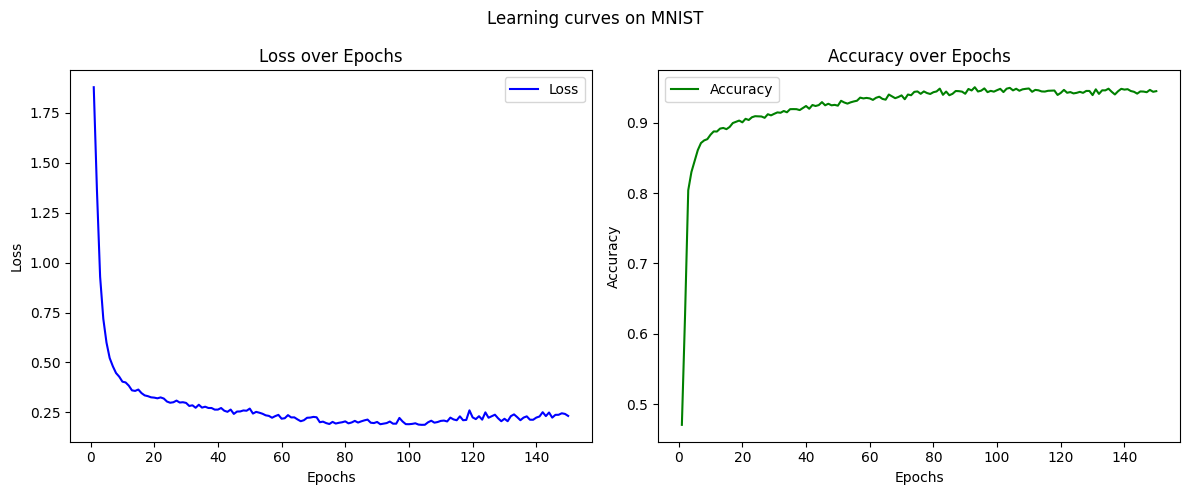

In [27]:
import time

start = time.time()
losses, accuracies, elapsed = train_n_rounds(pool_mnist, n_rounds=MNIST_ROUNDS, clients_per_round=3, problem="mnist")
end = time.time()

save_data(pool_mnist, losses, accuracies, elapsed, f"greedy_mnist_{MNIST_ROUNDS}.csv")

print(f"Training time: {end - start} sec")
plot_loss_accuracy(losses, accuracies, title="Learning curves on MNIST")

# Experimento 1: CIFAR-10

Ahora vamos a realizar el entrenamiento del modelo de CNN con CIFAR-10 para el que tenemos la siguiente configuración:
- $T=100$
- $M=6$

Y vamos a obtener las mismas métricas que con MNIST.

Además de esto, vamos a redefinir la función de entrenamiento para que podamos entrenar por _checkpoints_, es decir, guardar una memoria para poder correr el algoritmo desde un punto de partida. Para ello, hacemos que un diccionario se pase como parámetro de manera que reinicialice los valores de estado, y que devuelva además de las métricas, la memoria modificada con los valores de finalización de la ejecución. Lo hacemos de esta manera para poder realizar varias ejecuciones en caso de que se agoten las cuotas de tiempo de Colab.

In [27]:
import time
from typing import Optional
from torch import topk

from flex.data import Dataset

def train_n_rounds_with_memory(pool: FlexModel, n_rounds: int, clients_per_round=20, problem: Problem = "mnist", memo: Optional[dict] = None):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve and assign to server
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    def set_transforms(server_model, _):
        server_model["transforms"] = transforms
    pool.servers.map(set_transforms)

    # assign validation dataset to server
    val_data = mnist_val_data if problem == "mnist" else cifar_val_data
    flex_val_data = Dataset.from_torchvision_dataset(val_data)
    pool.servers.map(save_validation_data, val_data=flex_val_data)

    num_clients = len(pool.clients)
    
    if memo:
        UCB = memo["UCB"]
        SV = memo["SV"]
        SV_curr = memo["SV_curr"]
        N_t = memo["N_t"]
        losses = memo["losses"]
        accuracies = memo["accuracies"]
        elapsed_round_times = memo["elapsed_round_times"]
        i = memo["i"]
    else:
        UCB = [0 for i in range(num_clients)]
        SV = [0 for i in range(num_clients)]
        SV_curr = [0 for i in range(num_clients)]
        N_t = [0 for i in range(num_clients)]
        losses = []
        accuracies = []
        elapsed_round_times = []
        i = 0
        
    while i < n_rounds:
        start = time.time()
        print(f"\nRunning round: {i+1} of {n_rounds}")

        # select clients to transmit weights to
        # initially sample every client atleast once (RR)
        selected = [False for _ in range(num_clients)]
        if i < np.floor(num_clients / clients_per_round):
            print("RR round")
            for idx in range(i * clients_per_round, (i + 1) * clients_per_round):
                selected[idx] = True
                N_t[idx] += 1
        elif i == np.floor(num_clients / clients_per_round):
            print("Last RR round")
            for idx in range(i * clients_per_round, num_clients):
                selected[idx] = True
                N_t[idx] += 1

            remaining_selections = clients_per_round * (i + 1) - num_clients
            if remaining_selections > 0:
                unselected_indices = list(range(0, i * clients_per_round))
                selected_indices_subset = np.random.choice(
                    unselected_indices, size=remaining_selections, replace=False
                )

                for idx in selected_indices_subset:
                    selected[idx] = True
                    N_t[idx] += 1
        else:
            # UCB Greedy Selection (select clients with highest SV)
            _, selected_indices = topk(torch.Tensor(UCB), clients_per_round)
            print("Best selected: ", selected_indices)
            for idx in selected_indices.tolist():
                selected[idx] = True
                N_t[idx] += 1

        # take selected clients
        selected_indices = [index for index, value in enumerate(selected) if value]
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in selected_indices)
        selected_clients = selected_clients_pool.clients

        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)

        # Each selected client trains its model
        selected_clients.map(train, transforms=transforms)

        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)

        # The aggregator aggregates client updates with FedAveraging
        pool.aggregators.map(aggregate_with_fedavg)

        # compute SV values for each selected client in the server
        shapley_values = pool.aggregators.map(shapley_values_gtg, selected_clients)[0]

        print("GTG-Shapley values: ", shapley_values)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)

        # compute the cumulative SV for each client
        counter = 0
        for k in range(num_clients):
            if selected[k]:
                SV_curr[k] = shapley_values[counter]

                # previous num selections weight/penalty
                prev_wt = (N_t[k] - 1) / N_t[k]
                # current num selections weight/penalty
                curr_wt = 1 - prev_wt   # 1 / N_t[k]

                # previous cumulative SV
                prev_sv = SV[k]

                # t-round SV
                curr_sv = SV_curr[k]

                # compute new cumulative SV
                SV[k] = prev_wt * prev_sv + curr_wt * curr_sv

                counter += 1
            else:
                SV_curr[k] = 0

            UCB[k] = SV[k]

        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]

        end = time.time()

        losses.append(loss)
        accuracies.append(acc)
        elapsed_round_times.append(end - start)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}, round time: {end - start} sec")
        
        i += 1
        
    memo = {
        "UCB": UCB,
        "SV": SV,
        "SV_curr": SV_curr,
        "N_t": N_t,
        "losses": losses,
        "accuracies": accuracies,
        "elapsed_round_times": elapsed_round_times,
        "i": i
    }

    return losses, accuracies, elapsed_round_times, memo

Redefinimos la función `save_data` para guardar el estado del modelo de PyTorch así como la memoria de la ejecución para poder marcar un punto de guardado sobre diferentes ejecuciones.

In [28]:
import pandas as pd
import pickle

def save_data(model, losses, accuracies, elapsed, memo, filename):
    df = pd.DataFrame({
        "loss": losses,
        "accuracy": accuracies,
        "elapsed_time": elapsed
    })

    # save data for MNIST
    df.to_csv(f"{filename}.csv", index=False)

    display(df)
    
    # save memory
    with open(f"{filename}_memo.pkl", "wb") as file:
        pickle.dump(memo, file)

    # save model
    torch.save(model.state_dict(), f"{filename}.pth")

Definimos una función para obtener el modelo a partir de la _pool_ de servidores.

In [29]:
from flex.model import FlexModel
from flex.data import Dataset

def get_model(server: FlexModel, test_data: Dataset):
    return server["model"]

model = pool_cifar.servers.map(get_model)[0]
model

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=392, out_features=10, bias=True)
)

Definimos una función para cargar el estado de un modelo de PyTorch en el servidor.

In [30]:
import torch
from flex.model import FlexModel
from flex.data import Dataset

def load_model_state(server: FlexModel, test_data: Dataset, **kwargs):
    model_filename = kwargs["model_filename"]
    server["model"].load_state_dict(torch.load(model_filename))

Ejecutamos el entrenamiento en ejecuciones de $20$ rondas, lo que nos daría un total de $\lceil \frac{T}{20}\rceil = 5$ ejecuciones en total. Antes de cada ejecución (a excepción de la primera) le vamos a pasar la memoria o estado de ejecución de la anterior, y cargamos en la _pool_ el modelo guardado, hasta completar las cinco ejecuciones.

In [31]:
import os

# CHANGE FOR THE RUN CHECKPOINT TO USE
root_path = "."

In [32]:
round_interval = CIFAR_ROUNDS // 5

start = time.time()
losses, accuracies, elapsed, memo = train_n_rounds_with_memory(
    pool_cifar,
    n_rounds=round_interval,
    clients_per_round=6,
    problem="cifar"
)
end = time.time()

# get and save model state
model = pool_cifar.servers.map(get_model)[0]
save_data(model, losses, accuracies, elapsed, memo, f"greedy_cifar_{CIFAR_ROUNDS}_1")

print(f"Training time: {end - start} sec")

/opt/conda/lib/python3.10/site-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(



Running round: 1 of 20
RR round
Selected clients for this round: 6
GTG-Shapley lasted: 148.43246459960938 seconds to complete
GTG-Shapley values:  [0.02066928396622347, -0.008568874994913692, 0.008643794059753407, -0.009318470954895056, 0.007752210895220435, 0.00443886518478398]
Server: Test acc: 0.1303, test loss: 2.2936, round time: 157.1057448387146 sec

Running round: 2 of 20
RR round
Selected clients for this round: 6
GTG-Shapley lasted: 145.96480250358582 seconds to complete
GTG-Shapley values:  [0.02212903400262195, 0.01904633790254586, 0.02524277071158093, 0.016324476401011128, 0.018515220284461936, 0.019224387904008267]
Server: Test acc: 0.2339, test loss: 2.2139, round time: 153.7873890399933 sec

Running round: 3 of 20
RR round
Selected clients for this round: 6
GTG-Shapley lasted: 146.8137981891632 seconds to complete
GTG-Shapley values:  [0.025136799613634686, 0.012478398531675289, 0.00834057281414663, 0.03743296911319099, 0.01556889464457828, 0.028032179425160064]
Server

,loss,accuracy,elapsed_time
0,2.293639,0.1303,157.105745
1,2.213879,0.2339,153.787389
2,2.134027,0.2528,154.760225
3,2.021053,0.3425,156.188228
4,1.956217,0.3449,159.460860
5,1.910231,0.3468,157.413450
6,1.867600,0.3493,158.565445
7,1.874233,0.3548,197.369384
8,1.844800,0.3656,187.799242
9,1.833156,0.3638,154.863097


Training time: 4694.76344704628 sec


In [32]:
round_interval = CIFAR_ROUNDS // 5

# load model
pool_cifar.servers.map(load_model_state, model_filename=f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_1.pth')}")
# load memory
with open(f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_1_memo.pkl')}", "rb") as file:
    memo = pickle.load(file)

start = time.time()
losses, accuracies, elapsed, memo = train_n_rounds_with_memory(
    pool_cifar,
    n_rounds=round_interval * 2,
    clients_per_round=6,
    problem="cifar",
    memo=memo
)
end = time.time()

# get and save model state
model = pool_cifar.servers.map(get_model)[0]
save_data(model, losses, accuracies, elapsed, memo, f"greedy_cifar_{CIFAR_ROUNDS}_2")

print(f"Training time: {end - start} sec")

/opt/conda/lib/python3.10/site-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(



Running round: 21 of 40
Best selected:  tensor([25, 22, 21, 27, 16, 41])
Selected clients for this round: 6
GTG-Shapley lasted: 1021.9352622032166 seconds to complete
GTG-Shapley values:  [0.004445422346564531, 0.007742193204233019, -0.00811374369023861, 0.003773513915895038, -0.0012487798929214672, -0.004984477367894412]
Server: Test acc: 0.3411, test loss: 1.8952, round time: 1030.817771434784 sec

Running round: 22 of 40
Best selected:  tensor([18, 26, 32, 15,  6, 53])
Selected clients for this round: 6
GTG-Shapley lasted: 224.0690951347351 seconds to complete
GTG-Shapley values:  [0.0011577097906006533, 0.01076743702093762, -0.0007371625966495827, 0.0004921456178029625, 0.001425077683395812, 0.006457205944591148]
Server: Test acc: 0.3482, test loss: 1.8594, round time: 232.0737702846527 sec

Running round: 23 of 40
Best selected:  tensor([17, 15, 21, 23, 25, 13])
Selected clients for this round: 6
not converged in SV GTG
GTG-Shapley lasted: 1087.315143585205 seconds to complete
GT

,loss,accuracy,elapsed_time
0,2.293639,0.1303,157.105745
1,2.213879,0.2339,153.787389
2,2.134027,0.2528,154.760225
3,2.021053,0.3425,156.188228
4,1.956217,0.3449,159.460860
5,1.910231,0.3468,157.413450
6,1.867600,0.3493,158.565445
7,1.874233,0.3548,197.369384
8,1.844800,0.3656,187.799242
9,1.833156,0.3638,154.863097


Training time: 13377.838193655014 sec


In [32]:
round_interval = CIFAR_ROUNDS // 5

# load model
pool_cifar.servers.map(load_model_state, model_filename=f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_2.pth')}")
# load memory
with open(f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_2_memo.pkl')}", "rb") as file:
    memo = pickle.load(file)

start = time.time()
losses, accuracies, elapsed, memo = train_n_rounds_with_memory(
    pool_cifar,
    n_rounds=round_interval * 3,
    clients_per_round=6,
    problem="cifar",
    memo=memo
)
end = time.time()

# get and save model state
model = pool_cifar.servers.map(get_model)[0]
save_data(model, losses, accuracies, elapsed, memo, f"greedy_cifar_{CIFAR_ROUNDS}_3")

print(f"Training time: {end - start} sec")

/opt/conda/lib/python3.10/site-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(



Running round: 41 of 60
Best selected:  tensor([59, 29, 35, 52, 76, 14])
Selected clients for this round: 6
not converged in SV GTG
GTG-Shapley lasted: 1220.7338502407074 seconds to complete
GTG-Shapley values:  [0.0035806475745307226, 0.00019024329053030697, -0.0011884683701727042, 0.002117122941546973, -0.0019494584533903242, -0.004180078473356028]
Server: Test acc: 0.3385, test loss: 1.9409, round time: 1231.7185173034668 sec

Running round: 42 of 60
Best selected:  tensor([32, 53, 18, 74, 15, 55])
Selected clients for this round: 6
not converged in SV GTG
GTG-Shapley lasted: 1222.9360008239746 seconds to complete
GTG-Shapley values:  [-0.00046812464793521974, -4.760924312802527e-05, 0.001499822437763227, 0.0055312398076057335, 0.0019716760847303667, -0.010464282400078228]
Server: Test acc: 0.3317, test loss: 2.0006, round time: 1231.0317714214325 sec

Running round: 43 of 60
Best selected:  tensor([53, 12, 61, 21,  4, 24])
Selected clients for this round: 6
GTG-Shapley lasted: 114

,loss,accuracy,elapsed_time
0,2.293639,0.1303,157.105745
1,2.213879,0.2339,153.787389
2,2.134027,0.2528,154.760225
3,2.021053,0.3425,156.188228
4,1.956217,0.3449,159.460860
5,1.910231,0.3468,157.413450
6,1.867600,0.3493,158.565445
7,1.874233,0.3548,197.369384
8,1.844800,0.3656,187.799242
9,1.833156,0.3638,154.863097


Training time: 18842.33980488777 sec


In [32]:
round_interval = CIFAR_ROUNDS // 5

# load model
pool_cifar.servers.map(load_model_state, model_filename=f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_3.pth')}")
# load memory
with open(f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_3_memo.pkl')}", "rb") as file:
    memo = pickle.load(file)

start = time.time()
losses, accuracies, elapsed, memo = train_n_rounds_with_memory(
    pool_cifar,
    n_rounds=round_interval * 4,
    clients_per_round=6,
    problem="cifar",
    memo=memo
)
end = time.time()

# get and save model state
model = pool_cifar.servers.map(get_model)[0]
save_data(model, losses, accuracies, elapsed, memo, f"greedy_cifar_{CIFAR_ROUNDS}_4")

print(f"Training time: {end - start} sec")

/opt/conda/lib/python3.10/site-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(



Running round: 61 of 80
Best selected:  tensor([66, 29, 25, 10, 53,  7])
Selected clients for this round: 6
not converged in SV GTG
GTG-Shapley lasted: 1081.8080277442932 seconds to complete
GTG-Shapley values:  [-0.0030294595658779235, 0.0016223962770567874, 0.0005429874691698114, -0.0015193748142984182, 0.000895449419816327, 0.0012793700562583063]
Server: Test acc: 0.3309, test loss: 2.0755, round time: 1091.937915802002 sec

Running round: 62 of 80
Best selected:  tensor([31, 24, 11, 39, 59, 33])
Selected clients for this round: 6
GTG-Shapley lasted: 552.1929802894592 seconds to complete
GTG-Shapley values:  [0.004082676900757699, 0.002073294321695955, 0.00018351276715597496, -0.0006786352396011268, -0.0035313728782865833, 0.0005105482869678037]
Server: Test acc: 0.3364, test loss: 2.0242, round time: 559.8924353122711 sec

Running round: 63 of 80
Best selected:  tensor([11,  0, 21,  4,  9, 32])
Selected clients for this round: 6
not converged in SV GTG
GTG-Shapley lasted: 1114.436

,loss,accuracy,elapsed_time
0,2.293639,0.1303,157.105745
1,2.213879,0.2339,153.787389
2,2.134027,0.2528,154.760225
3,2.021053,0.3425,156.188228
4,1.956217,0.3449,159.460860
...,...,...,...
75,1.982321,0.3496,1117.009989
76,2.063397,0.3433,594.292728
77,2.014114,0.3469,1109.245790
78,2.064708,0.3391,404.385504


Training time: 18090.960875034332 sec


In [32]:
round_interval = CIFAR_ROUNDS // 5

# load model
pool_cifar.servers.map(load_model_state, model_filename=f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_4.pth')}")
# load memory
with open(f"{os.path.join(root_path, f'greedy_cifar_{CIFAR_ROUNDS}_4_memo.pkl')}", "rb") as file:
    memo = pickle.load(file)

start = time.time()
losses, accuracies, elapsed, memo = train_n_rounds_with_memory(
    pool_cifar,
    n_rounds=round_interval * 5,
    clients_per_round=6,
    problem="cifar",
    memo=memo
)
end = time.time()

# get and save model state
model = pool_cifar.servers.map(get_model)[0]
save_data(model, losses, accuracies, elapsed, memo, f"greedy_cifar_{CIFAR_ROUNDS}_5")

print(f"Training time: {end - start} sec")

/opt/conda/lib/python3.10/site-packages/flex/data/dataset.py:130: RuntimeWarning: The input dataset and arguments are not explicitly supported, therefore they might not work as expected.
  warnings.warn(



Running round: 81 of 100
Best selected:  tensor([93, 34, 15, 32,  0, 53])
Selected clients for this round: 6
not converged in SV GTG
GTG-Shapley lasted: 1178.1546156406403 seconds to complete
GTG-Shapley values:  [-0.010749194754494564, 0.003518231312433883, -0.004103610350026018, 0.0044146353668636715, 0.002058498180574834, -0.0022299238542715667]
Server: Test acc: 0.3405, test loss: 2.0594, round time: 1189.4616079330444 sec

Running round: 82 of 100
Best selected:  tensor([34, 15, 66, 16, 43, 21])
Selected clients for this round: 6
GTG-Shapley lasted: 200.4534285068512 seconds to complete
GTG-Shapley values:  [0.0032358398040135553, 0.0036108533541361347, 0.003908822337786341, 0.001059738596280398, 0.003304361104965185, -0.0006573285659154419]
Server: Test acc: 0.3365, test loss: 2.0228, round time: 208.85475063323975 sec

Running round: 83 of 100
Best selected:  tensor([43, 16, 15, 34, 21, 29])
Selected clients for this round: 6
GTG-Shapley lasted: 359.4694936275482 seconds to com

,loss,accuracy,elapsed_time
0,2.293639,0.1303,157.105745
1,2.213879,0.2339,153.787389
2,2.134027,0.2528,154.760225
3,2.021053,0.3425,156.188228
4,1.956217,0.3449,159.460860
...,...,...,...
95,2.042819,0.3376,1092.705734
96,2.076680,0.3331,9.552227
97,2.041567,0.3330,1104.953046
98,2.087298,0.3260,1149.461611


Training time: 16063.279443025589 sec


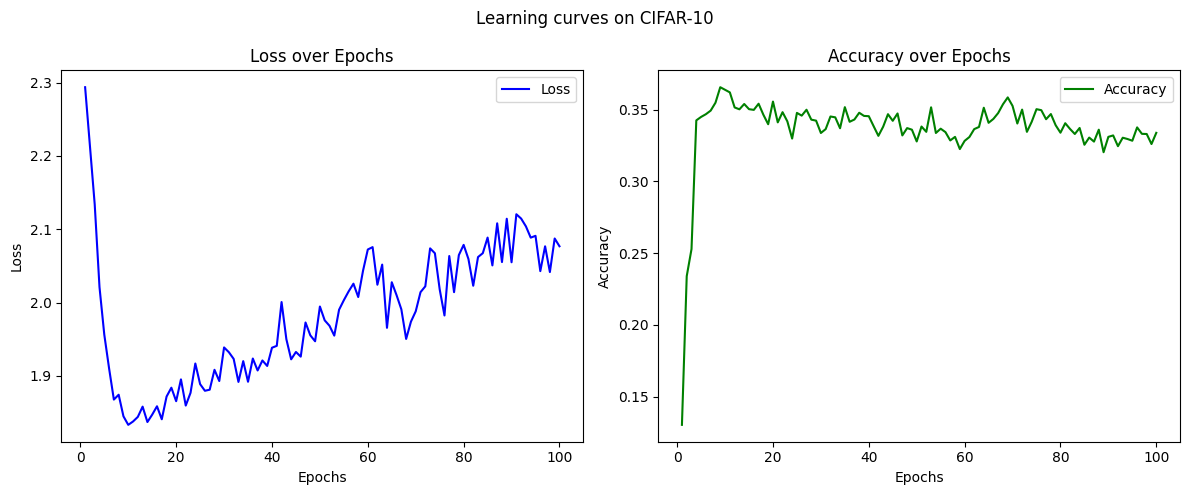

In [33]:
plot_loss_accuracy(losses, accuracies, title="Learning curves on CIFAR-10")